Generative Adversarial Networks (GANs)
======
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Parameter Settings
-------------------


In [3]:
latent_dims = 10
num_epochs = 1
batch_size = 128
learning_rate = 2e-4
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We scale to 64x64 so we can have a deeper architecture with more down-sampling steps. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.

In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



torch.Size([128, 1, 64, 64])


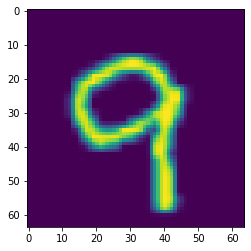

In [5]:
import matplotlib.pyplot as plt
images = iter(train_dataloader).next()
print(images[0].size())
# visualize a sample
plt.imshow(images[0][0][0])


GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [6]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x
    
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12656257 and discriminator: 11033985


Train GAN
--------


In [ ]:
from tqdm import tqdm
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta_1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in tqdm(range(num_epochs)):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...


  0%|          | 0/20 [06:29<?, ?it/s]


KeyboardInterrupt: ignored

Plot Training Curves
--------------------

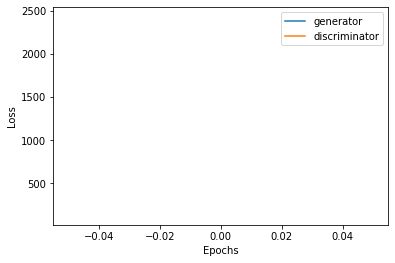

In [ ]:
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Alternatively: Load Pre-Trained GAN
-----------------------------

In [7]:
# import pretrained weights
generator.load_state_dict(torch.load('/content/drive/MyDrive/ME592_GANs/pretrained/my_dcgan.pth'))
# discriminator.load_state_dict(torch.load('./pretrained/dcgan_discriminator.pth'))
print('done')

# this is how the GAN parameters can be saved:
# torch.save(generator.state_dict(), './pretrained/my_dcgan.pth')
# torch.save(discriminator.state_dict(), './pretrained/my_dcgan_discriminator.pth')

done


Interpolate in Latent Space
----------------------------

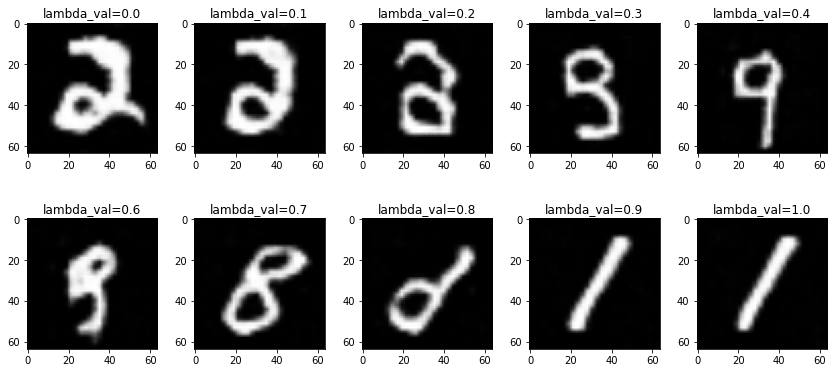

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

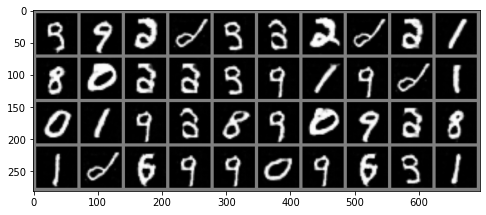

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(40, 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer_1 = nn.Linear(1, 32)
        self.layer_2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer_1(x))
        return self.layer_2(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer_1 = nn.Linear(1, 32)
        self.layer_2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.sigmoid(self.layer_1(x))
        return self.layer_2(x)


In [11]:
# Lets generate our data set
# In this toy case our dataset will be a lognormal distribution

num_samples = 1000

# gaussian noise -> qGenerator -> ~ sample from log-norm dist 
#                                 "true" sample from log-norm dist
# discrim learns log-norm dist by comparing generated and "true" samples
true_data_dist = np.random.lognormal(mean=1, sigma=1, size=num_samples)

bounds = np.array([0.0, 7.0])

generator = Generator()
discriminator = Discriminator()


# Below function is for a final visualization
# compute dist for comp with np.random.lognormal
def compute_dist():
    # Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
    preds = generator(torch.randn((100000,1)).float()).detach().numpy()
    # round it out
    preds = np.round(preds)
    preds = preds[preds <= bounds[1]]
    temp = []
    for i in range(int(bounds[1] + 1)):
        temp += [np.sum(preds == i)]
    preds = np.array(temp / sum(temp))
    return preds


untrained_dist = compute_dist()
untrained_dist = untrained_dist.flatten()

In [12]:
epochs = 100

generator = Generator()
discriminator = Discriminator()


gen_optimizer = torch.optim.Adam(params=generator.parameters())
disc_optimizer = torch.optim.Adam(params=discriminator.parameters())

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []
relative_entropy_avg = []

print('Training ...')
for epoch in tqdm(range(epochs)):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    index = 0
    num_batches = 0

    while (index + 32) <= 1000:
        batch = torch.from_numpy(true_data_dist[index : index + 32]).unsqueeze(-1)
        # print('batch = ', batch.shape)
        index += 32
        valid = torch.ones_like(batch)
        fake = torch.zeros_like(batch)

        #freeze d
        for p in discriminator.parameters(): p.requires_grad_(False)
        for p in generator.parameters(): p.requires_grad_(True)
        for p in generator.parameters(): p.grad=None

        generated_samples = generator(torch.randn_like(batch).float())
        gen_disc = discriminator(generated_samples)
        # print('gen dims = ', generated_samples.shape)
        # print('target dims = ', batch.shape)
        gen_loss = F.binary_cross_entropy_with_logits(gen_disc, valid)

        gen_loss.backward()
        gen_optimizer.step()

        # freeze g, unfreeze d
        for p in generator.parameters(): p.requires_grad_(False)
        for p in discriminator.parameters(): p.requires_grad_(True)
        for p in discriminator.parameters(): p.grad=None

        gen_data_dist = generator(torch.randn_like(batch).float())

        real_pred = discriminator(batch.float())
        fake_pred = discriminator(gen_data_dist)

        disc_loss = 0.5 * (
            F.binary_cross_entropy_with_logits(real_pred, valid.float()) +
            F.binary_cross_entropy_with_logits(fake_pred, fake.float()))

        disc_loss.backward()
        disc_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...


  2%|▏         | 2/100 [00:00<00:07, 12.95it/s]

Epoch [1 / 1] average loss generator vs. discrim.: 0.760096 vs. 0.644366
Epoch [2 / 1] average loss generator vs. discrim.: 0.704092 vs. 0.624162


  4%|▍         | 4/100 [00:00<00:06, 14.36it/s]

Epoch [3 / 1] average loss generator vs. discrim.: 0.706105 vs. 0.636791
Epoch [4 / 1] average loss generator vs. discrim.: 0.713247 vs. 0.661552


  6%|▌         | 6/100 [00:00<00:06, 15.20it/s]

Epoch [5 / 1] average loss generator vs. discrim.: 0.710599 vs. 0.687271
Epoch [6 / 1] average loss generator vs. discrim.: 0.706432 vs. 0.706610


  8%|▊         | 8/100 [00:00<00:05, 15.64it/s]

Epoch [7 / 1] average loss generator vs. discrim.: 0.705897 vs. 0.716177
Epoch [8 / 1] average loss generator vs. discrim.: 0.709342 vs. 0.716021


 10%|█         | 10/100 [00:00<00:05, 15.60it/s]

Epoch [9 / 1] average loss generator vs. discrim.: 0.717064 vs. 0.708883
Epoch [10 / 1] average loss generator vs. discrim.: 0.728221 vs. 0.697249


 12%|█▏        | 12/100 [00:00<00:05, 15.44it/s]

Epoch [11 / 1] average loss generator vs. discrim.: 0.741205 vs. 0.683419
Epoch [12 / 1] average loss generator vs. discrim.: 0.754266 vs. 0.669217


 14%|█▍        | 14/100 [00:00<00:05, 15.49it/s]

Epoch [13 / 1] average loss generator vs. discrim.: 0.766420 vs. 0.656266
Epoch [14 / 1] average loss generator vs. discrim.: 0.775330 vs. 0.646121


 16%|█▌        | 16/100 [00:01<00:05, 15.17it/s]

Epoch [15 / 1] average loss generator vs. discrim.: 0.779339 vs. 0.639964
Epoch [16 / 1] average loss generator vs. discrim.: 0.775361 vs. 0.639245


 18%|█▊        | 18/100 [00:01<00:05, 15.48it/s]

Epoch [17 / 1] average loss generator vs. discrim.: 0.759291 vs. 0.646060
Epoch [18 / 1] average loss generator vs. discrim.: 0.726403 vs. 0.664854


 20%|██        | 20/100 [00:01<00:05, 15.83it/s]

Epoch [19 / 1] average loss generator vs. discrim.: 0.661312 vs. 0.703682
Epoch [20 / 1] average loss generator vs. discrim.: 0.581797 vs. 0.746581


 22%|██▏       | 22/100 [00:01<00:04, 16.16it/s]

Epoch [21 / 1] average loss generator vs. discrim.: 0.605009 vs. 0.686363
Epoch [22 / 1] average loss generator vs. discrim.: 0.752028 vs. 0.552021


 24%|██▍       | 24/100 [00:01<00:04, 15.80it/s]

Epoch [23 / 1] average loss generator vs. discrim.: 0.823740 vs. 0.525494
Epoch [24 / 1] average loss generator vs. discrim.: 0.795683 vs. 0.610651


 26%|██▌       | 26/100 [00:01<00:04, 15.71it/s]

Epoch [25 / 1] average loss generator vs. discrim.: 0.739385 vs. 0.715277
Epoch [26 / 1] average loss generator vs. discrim.: 0.711410 vs. 0.773280


 28%|██▊       | 28/100 [00:01<00:04, 15.45it/s]

Epoch [27 / 1] average loss generator vs. discrim.: 0.703143 vs. 0.780177
Epoch [28 / 1] average loss generator vs. discrim.: 0.716802 vs. 0.759954


 30%|███       | 30/100 [00:01<00:04, 15.49it/s]

Epoch [29 / 1] average loss generator vs. discrim.: 0.738482 vs. 0.727908
Epoch [30 / 1] average loss generator vs. discrim.: 0.764282 vs. 0.694384


 32%|███▏      | 32/100 [00:02<00:04, 15.27it/s]

Epoch [31 / 1] average loss generator vs. discrim.: 0.791905 vs. 0.664272
Epoch [32 / 1] average loss generator vs. discrim.: 0.819584 vs. 0.637411


 34%|███▍      | 34/100 [00:02<00:04, 15.45it/s]

Epoch [33 / 1] average loss generator vs. discrim.: 0.846388 vs. 0.612975
Epoch [34 / 1] average loss generator vs. discrim.: 0.871906 vs. 0.591435


 36%|███▌      | 36/100 [00:02<00:04, 15.46it/s]

Epoch [35 / 1] average loss generator vs. discrim.: 0.891356 vs. 0.575030
Epoch [36 / 1] average loss generator vs. discrim.: 0.902443 vs. 0.569080


 38%|███▊      | 38/100 [00:02<00:04, 15.22it/s]

Epoch [37 / 1] average loss generator vs. discrim.: 0.889558 vs. 0.573283
Epoch [38 / 1] average loss generator vs. discrim.: 0.860560 vs. 0.589574
Epoch [39 / 1] average loss generator vs. discrim.: 0.810181 vs. 0.621177


 42%|████▏     | 42/100 [00:02<00:03, 15.39it/s]

Epoch [40 / 1] average loss generator vs. discrim.: 0.726554 vs. 0.673861
Epoch [41 / 1] average loss generator vs. discrim.: 0.605623 vs. 0.762455
Epoch [42 / 1] average loss generator vs. discrim.: 0.483431 vs. 0.857377
Epoch [43 / 1] average loss generator vs. discrim.: 0.455410 vs. 0.840587


 46%|████▌     | 46/100 [00:02<00:03, 15.92it/s]

Epoch [44 / 1] average loss generator vs. discrim.: 0.543734 vs. 0.711424
Epoch [45 / 1] average loss generator vs. discrim.: 0.666554 vs. 0.604402
Epoch [46 / 1] average loss generator vs. discrim.: 0.747019 vs. 0.572755
Epoch [47 / 1] average loss generator vs. discrim.: 0.778882 vs. 0.589275


 50%|█████     | 50/100 [00:03<00:03, 15.51it/s]

Epoch [48 / 1] average loss generator vs. discrim.: 0.781405 vs. 0.628612
Epoch [49 / 1] average loss generator vs. discrim.: 0.771252 vs. 0.672032
Epoch [50 / 1] average loss generator vs. discrim.: 0.752783 vs. 0.707810


 54%|█████▍    | 54/100 [00:03<00:02, 16.20it/s]

Epoch [51 / 1] average loss generator vs. discrim.: 0.750808 vs. 0.724482
Epoch [52 / 1] average loss generator vs. discrim.: 0.755534 vs. 0.721417
Epoch [53 / 1] average loss generator vs. discrim.: 0.762009 vs. 0.704351
Epoch [54 / 1] average loss generator vs. discrim.: 0.787197 vs. 0.682004


 58%|█████▊    | 58/100 [00:03<00:02, 16.14it/s]

Epoch [55 / 1] average loss generator vs. discrim.: 0.809184 vs. 0.654888
Epoch [56 / 1] average loss generator vs. discrim.: 0.831213 vs. 0.630209
Epoch [57 / 1] average loss generator vs. discrim.: 0.852242 vs. 0.609240
Epoch [58 / 1] average loss generator vs. discrim.: 0.870545 vs. 0.592697


 62%|██████▏   | 62/100 [00:03<00:02, 16.30it/s]

Epoch [59 / 1] average loss generator vs. discrim.: 0.883724 vs. 0.581723
Epoch [60 / 1] average loss generator vs. discrim.: 0.890450 vs. 0.577475
Epoch [61 / 1] average loss generator vs. discrim.: 0.880290 vs. 0.579992
Epoch [62 / 1] average loss generator vs. discrim.: 0.867499 vs. 0.588046


 66%|██████▌   | 66/100 [00:04<00:02, 15.88it/s]

Epoch [63 / 1] average loss generator vs. discrim.: 0.846354 vs. 0.614076
Epoch [64 / 1] average loss generator vs. discrim.: 0.789553 vs. 0.631486
Epoch [65 / 1] average loss generator vs. discrim.: 0.751374 vs. 0.663458
Epoch [66 / 1] average loss generator vs. discrim.: 0.698071 vs. 0.700084


 70%|███████   | 70/100 [00:04<00:01, 16.22it/s]

Epoch [67 / 1] average loss generator vs. discrim.: 0.620251 vs. 0.742433
Epoch [68 / 1] average loss generator vs. discrim.: 0.547675 vs. 0.771087
Epoch [69 / 1] average loss generator vs. discrim.: 0.566146 vs. 0.717998
Epoch [70 / 1] average loss generator vs. discrim.: 0.662083 vs. 0.624710


 72%|███████▏  | 72/100 [00:04<00:01, 16.21it/s]

Epoch [71 / 1] average loss generator vs. discrim.: 0.755362 vs. 0.577169
Epoch [72 / 1] average loss generator vs. discrim.: 0.806779 vs. 0.572202
Epoch [73 / 1] average loss generator vs. discrim.: 0.820592 vs. 0.603104


 76%|███████▌  | 76/100 [00:04<00:01, 15.53it/s]

Epoch [74 / 1] average loss generator vs. discrim.: 0.796021 vs. 0.650547
Epoch [75 / 1] average loss generator vs. discrim.: 0.796295 vs. 0.708713
Epoch [76 / 1] average loss generator vs. discrim.: 0.761803 vs. 0.733821
Epoch [77 / 1] average loss generator vs. discrim.: 0.767589 vs. 0.743958


 80%|████████  | 80/100 [00:05<00:01, 15.45it/s]

Epoch [78 / 1] average loss generator vs. discrim.: 0.788689 vs. 0.728924
Epoch [79 / 1] average loss generator vs. discrim.: 0.788007 vs. 0.689391
Epoch [80 / 1] average loss generator vs. discrim.: 0.808892 vs. 0.661177
Epoch [81 / 1] average loss generator vs. discrim.: 0.828996 vs. 0.636580


 84%|████████▍ | 84/100 [00:05<00:00, 16.08it/s]

Epoch [82 / 1] average loss generator vs. discrim.: 0.840369 vs. 0.619266
Epoch [83 / 1] average loss generator vs. discrim.: 0.855913 vs. 0.609759
Epoch [84 / 1] average loss generator vs. discrim.: 0.866410 vs. 0.609920
Epoch [85 / 1] average loss generator vs. discrim.: 0.859361 vs. 0.611632


 88%|████████▊ | 88/100 [00:05<00:00, 16.30it/s]

Epoch [86 / 1] average loss generator vs. discrim.: 0.844064 vs. 0.622866
Epoch [87 / 1] average loss generator vs. discrim.: 0.838064 vs. 0.618990
Epoch [88 / 1] average loss generator vs. discrim.: 0.831189 vs. 0.640718
Epoch [89 / 1] average loss generator vs. discrim.: 0.807291 vs. 0.638611


 92%|█████████▏| 92/100 [00:05<00:00, 16.43it/s]

Epoch [90 / 1] average loss generator vs. discrim.: 0.811259 vs. 0.654430
Epoch [91 / 1] average loss generator vs. discrim.: 0.776140 vs. 0.660567
Epoch [92 / 1] average loss generator vs. discrim.: 0.756371 vs. 0.672461
Epoch [93 / 1] average loss generator vs. discrim.: 0.732715 vs. 0.682750


 96%|█████████▌| 96/100 [00:06<00:00, 15.80it/s]

Epoch [94 / 1] average loss generator vs. discrim.: 0.717353 vs. 0.679796
Epoch [95 / 1] average loss generator vs. discrim.: 0.701985 vs. 0.687986
Epoch [96 / 1] average loss generator vs. discrim.: 0.688553 vs. 0.688768
Epoch [97 / 1] average loss generator vs. discrim.: 0.692317 vs. 0.680763


100%|██████████| 100/100 [00:06<00:00, 15.71it/s]

Epoch [98 / 1] average loss generator vs. discrim.: 0.687799 vs. 0.670700
Epoch [99 / 1] average loss generator vs. discrim.: 0.706193 vs. 0.660719
Epoch [100 / 1] average loss generator vs. discrim.: 0.712634 vs. 0.652153


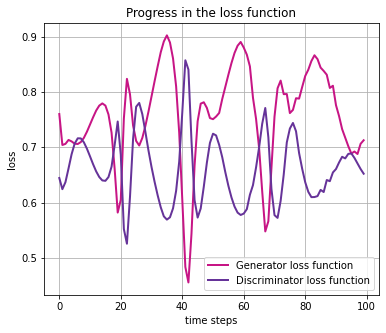

In [13]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(epochs)
plt.figure(figsize=(6, 5))
plt.title("Progress in the loss function")
plt.plot(
    t_steps, gen_loss_avg, label="Generator loss function", color="mediumvioletred", linewidth=2
)
plt.plot(
    t_steps, disc_loss_avg, label="Discriminator loss function", color="rebeccapurple", linewidth=2
)
plt.grid()
plt.legend(loc="best")
plt.xlabel("time steps")
plt.ylabel("loss")
plt.show()

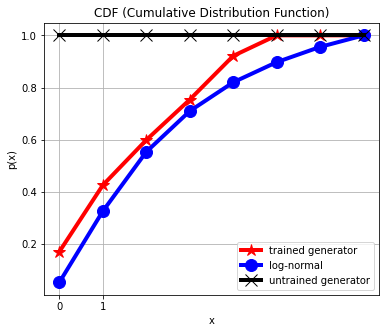

In [14]:
# Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal == i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6, 5))
plt.title("CDF (Cumulative Distribution Function)")
samples_g = compute_dist()
samples_g = samples_g.flatten()
plt.plot(
    np.cumsum(samples_g), "-*", label="trained generator", color="red", linewidth=4, markersize=12
)
plt.plot(
    np.cumsum(log_normal), "-o", label="log-normal", color="blue", linewidth=4, markersize=12
)
plt.plot(
    np.cumsum(untrained_dist), "-x", label="untrained generator", color="black", linewidth=4, markersize=12
)
plt.xticks(np.arange(min(samples_g), max(samples_g) + 1, 1.0))
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")
plt.show()